# A feed-forward neural network from scratch

## Helper functions

In [52]:
import numpy as np
import math
import random
from tqdm.notebook import tqdm

from matplotlib import pyplot

def sigmoid(x):
    if isinstance(x, np.ndarray):
        return np.array([sigmoid(_x) for _x in x])
    return 1 / (1 + math.exp(-x))
def sigmoid_prime(x):
    if isinstance(x, np.ndarray):
        return np.array([sigmoid_prime(_x) for _x in x])
    return sigmoid(x)*(1-sigmoid(x))

# add two arrays element-by-element
def add_arrays(a1, a2):
    return [x1 + x2 for x1, x2 in zip(a1, a2)]

# couldn't figure out how to cleanly multiply vectors as matrices...
def transpose_mul_vectors(v1, v2):
    return np.dot(v1.reshape(len(v1), 1), v2.reshape(1, len(v2)))


    

In [237]:
a1= [np.array([
    [1,2],
    [3,4]
]),
    np.array([
        [10, 20, 30],
        [30,40, 50]
    ])
    ]
a1

[array([[11, 22],
        [33, 44]]),
 array([[ 20,  40,  60],
        [ 60,  80, 100]])]

In [241]:
[w.shape for w in mynet.w]

[(30, 784), (10, 30)]

## The Network

In [527]:
class Network:
    def __init__(self, layer_sizes):
        # weights is an array of weight matricies
        self.w = []
        self.b = []
        self.z = []
        self.a = []
        
        self.layer_sizes = layer_sizes
        self.init_parameters()
      
    def init_parameters(self):
        # input layer --w[0]--> first layer --w[1]--> ... --w[n-1]--> n-th layer
        self.w = [np.random.randn(next_layer, layer) for next_layer, layer in zip(self.layer_sizes[1:], self.layer_sizes[:-1])]
        
        # input layer --b[0]--> first layer --b[1]--> ... --b[n-1]--> n-th layer
        self.b = [np.random.randn(layer_size) for layer_size in self.layer_sizes[1:]] 
        
        # input layer --a[0]--> first layer --a[1]--> ... n-th layer --a[n]-->
        self.init_activities()
        
    def init_activities(self, inputs=None):
        self.a = [np.empty(layer_size) for layer_size in self.layer_sizes]
        self.z = [np.empty(layer_size) for layer_size in self.layer_sizes]
        if inputs is not None:
            self.a[0] = inputs
            
    def feed_forward(self, inputs: np.ndarray):
        self.assert_input_shape(inputs)
        self.init_activities(inputs)
        i = 1
        while i < len(self.layer_sizes):
            prev_a = self.a[i-1]
            # sum(weights * previous activations) + bias for each neuron
            self.z[i] = np.dot(self.w[i-1], prev_a) + self.b[i-1]
            
            # pass through activation function
            self.a[i] = self.activation_function(self.z[i])
            
            i += 1
        return self.a[-1]
    
    def gradient(self, examples):
        """ computes the gradient for each individual example using backpropagation and averages them"""
        d_w = [np.zeros(w.shape) for w in self.w]
        d_b = [np.zeros(b.shape) for b in self.b]
        
        for x, y in examples:
            # gradient for a single example
            d_d_w, d_d_b = self.backprop(x, y)
            
            d_w = add_arrays(d_w, d_d_w)
            d_b = add_arrays(d_b, d_d_b)
            
        # average all the gradients from single examples
        
        d_w = [dw / len(examples) for dw in d_w]
        d_b = [db / len(examples) for db in d_b]
        return d_w, d_b
    
    def train(self, examples, eta):
        d_w, d_b = self.gradient(examples)
        
        
        self.w = [w - eta * dw for w, dw in zip(self.w, d_w)]
        self.b = [b - eta * db for b, db in zip(self.b, d_b)]
        
        
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        error_plot = []
        if test_data: n_test = len(test_data)
        n = len(training_data)
        with tqdm(total=epochs * n) as pbar:
            for j in range(epochs):
                random.shuffle(training_data)
                mini_batches = [
                    training_data[k:k+mini_batch_size]
                    for k in range(0, n, mini_batch_size)]
                for mini_batch in mini_batches:
                    self.train(mini_batch, eta)
                    pbar.update(len(mini_batch))
                if test_data:
                    error_plot.append(self.error(test_data))
                    print("Epoch {0}: {1}".format(
                        j, error_plot[j]))
                else:
                    print("Epoch {0} complete".format(j))
        return error_plot
                
    def assert_input_shape(self, x):
        assert (x.ndim == 1 and len(x) == self.layer_sizes[0]), "example input ({}) doesn't match network input shape ({})".format(x.shape, self.layer_sizes[0])
    def assert_output_shape(self, y):
        assert (y.ndim == 1 and len(y) == self.layer_sizes[-1]), "example output doesn't match network output shape"
    
    def backprop(self, x, y):
        """ Computes gradient of the cost function as derived from one example.
            Returns d_w, d_b (changes to be made to weights and biases)"""
        d_w = [np.zeros(w.shape) for w in self.w]
        d_b = [np.zeros(b.shape) for b in self.b]

        self.assert_input_shape(x)
        self.assert_output_shape(y)

        output = self.feed_forward(x)

        
        
        # compute error for the output layer (which happens to equal the bias gradient)
        error = (self.a[-1] - y) * self.activation_function_prime(self.z[-1])
        d_b[-1] = error
        d_w[-1] = transpose_mul_vectors(error, self.a[-2].transpose())

        # backpropagate the error
        for i, layer in reversed(list(enumerate(self.layer_sizes))[1:-1]):
            next_w = self.w[i]  # weights connecting this layer to next one
            error = np.dot(next_w.transpose(), error) * self.activation_function_prime(self.z[i])

            d_b[i-1] = error
            prev_a = self.a[i-1]  # activations of the previous layer)
            d_w[i-1] = transpose_mul_vectors(error, prev_a)

        return d_w, d_b
    
    def example_error(self, example):
        x, t = example
        y = self.feed_forward(x)
        return np.linalg.norm(t - y) ** 2
    
    def network_error(self, examples):
        avg = 0
        for example in examples:
            avg += self.example_error(example)
        return avg / (2 * len(examples))
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feed_forward(x)), np.argmax(y))
                        for x, y in test_data]
        return sum(int(t == y) for (y, t) in test_results)
    
    
    def activation_function(self, z):
        return sigmoid(z)
    
    def activation_function_prime(self, z):
        return sigmoid_prime(z)
    
    def error(self, examples):
        e_sum = 0
        for x, t in examples:
            y = self.feed_forward(x)
            e_sum += np.linalg.norm(t - y) ** 2
        return e_sum / (2 * len(examples))
    
    def b_as_matrix(self):
        "Convert biases to matrix form (fill with zeros)"
        max_layer_size = max(self.layer_sizes)
        num_layers = len(self.layer_sizes)
        
        bm = np.empty((num_layers, max_layer_size))
        
        i = 1
        while i < num_layers:
            padded_b = np.zeros(max_layer_size)
            padded_b[:len(self.b[i-1])] = self.b[i-1]
            bm[i] = padded_b
            i += 1
            
        return bm
    
    def random_examples(self, n):
        " Generates n random (input, output) pairs"
        return list(zip(np.random.rand(n, self.layer_sizes[0]), np.random.rand(n, self.layer_sizes[-1])))
    def gradient_check(self, full=False):
        """ Check the backprop implementation by comparing 
            computed partial derivatives to a limit calculation
            (< 1e-5 good). Caution: erases weights and biases!
        """
        examples = self.random_examples(1000)
        self.init_parameters()
        
        d_w, d_b = self.gradient(examples)
        approximations = []
        
        if full:
            k = 1
            while k < len(self.w):
                wk = self.w[k-1]
                for i in tqdm(range(len(wk))):
                    for j in range(len(wk[i])):
                        d_wk_i_j_approximation = self.gradient_lim_approximation(examples, 0.0001, wk, i, j)
                        approximations.append((d_wk_i_j_approximation, d_w[k-1][i][j]))
                    
                k += 1
        else:
            for n in tqdm(range(500)):
                # pick random layer 
                k = random.randrange(len(self.w))
                wk = self.w[k]
                
                i = random.randrange(len(wk))
                j = random.randrange(len(wk[i]))
                
                d_wk_i_j_approximation = self.gradient_lim_approximation(examples, 0.0001, wk, i, j)
                approximations.append((d_wk_i_j_approximation, d_w[k][i][j]))
                    
                
        return sum([abs(truth - approx) for truth, approx in approximations])
    def gradient_lim_approximation(self, examples, delta, wk, i, j):
        initial_wk_i_j = wk[i][j]

        wk[i][j] -= delta
        err_before = self.error(examples)

        wk[i][j] += 2 * delta
        err_after = self.error(examples)

        d_wk_i_j_approximation = (err_after - err_before) / (2 * delta)
        wk[i][j] = initial_wk_i_j
        
        return d_wk_i_j_approximation

## Linear separation
We're going to generate 10000 (x, y) coordinates and label them 0 when they're below y=x and 1 otherwise  

### Generate 10000 training points

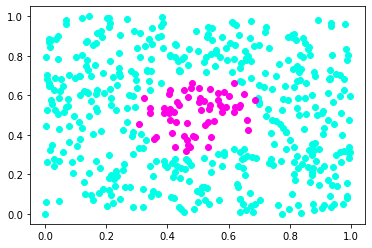

In [485]:
linear_examples = []
for i in range(10000):
    X = np.random.rand(2)
    y = np.array([1, 0]) if math.sqrt((X[1] - 0.5) ** 2 + (X[0] - 0.5) ** 2) < 0.2 else np.array([0, 1])
    if i < 500:
        pyplot.scatter(X[0], X[1], color=(y[0], y[1], 0.9))
    linear_examples.append((X, y))

In [491]:
linet = Network([2, 5, 2])
print("created network with layer sizes {}".format(linet.layer_sizes))

created network with layer sizes [2, 5, 2]


  0%|          | 0/400000 [00:00<?, ?it/s]

Epoch 0: 0.05403080290287386
Epoch 1: 0.04642888857319198
Epoch 2: 0.03902461685113057
Epoch 3: 0.037621667629654604
Epoch 4: 0.031670395367746025
Epoch 5: 0.03445540483287095
Epoch 6: 0.025056344983258896
Epoch 7: 0.026027372667361798
Epoch 8: 0.02476932066428421
Epoch 9: 0.02317434997729547
Epoch 10: 0.023367498075558643
Epoch 11: 0.01866769356849015
Epoch 12: 0.019598337087569157
Epoch 13: 0.020729744987577573
Epoch 14: 0.020608267020554825
Epoch 15: 0.016762557755510867
Epoch 16: 0.017138851669069585
Epoch 17: 0.020252919818354965
Epoch 18: 0.019395117893167665
Epoch 19: 0.014708571551358062
Epoch 20: 0.01572478327380643
Epoch 21: 0.014961612984363526
Epoch 22: 0.020728727094897023
Epoch 23: 0.016413631849145415
Epoch 24: 0.019672786187678492
Epoch 25: 0.016242745728367453
Epoch 26: 0.014150763860278175
Epoch 27: 0.014365427684082707
Epoch 28: 0.016883099333000983
Epoch 29: 0.01934377785384315
Epoch 30: 0.015506601423259051
Epoch 31: 0.018019395047169706
Epoch 32: 0.012832676621394

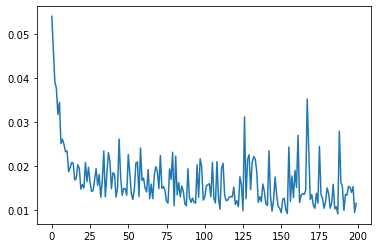

In [494]:
# for i in range(5):
error_plot = linet.SGD(linear_examples[:9000], 200, 10, 4, test_data=linear_examples[:1000])
#     network_paint()
fig = pyplot.figure()
ax = pyplot.axes()

ax.plot(range(len(error_plot)), error_plot)

### Let the network color 500 points

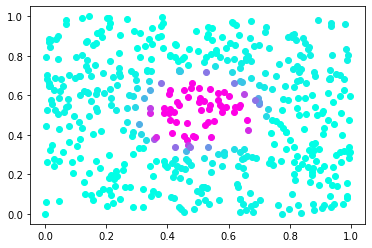

In [498]:
def network_paint():
    for ex in linear_examples[:500]:
        X = ex[0]
        y = linet.feed_forward(X)
        pyplot.scatter(X[0], X[1], color=(y[0], y[1], 0.9))
    pyplot.show()
        
network_paint()

## MNIST

### Loading the data

In [499]:
from tensorflow import keras

(raw_train_X, raw_train_y), (raw_test_X, raw_test_y) = keras.datasets.mnist.load_data()
print('X_train: ' + str(raw_train_X.shape))
print('Y_train: ' + str(raw_train_y.shape))
print('X_test:  '  + str(raw_test_X.shape))
print('Y_test:  '  + str(raw_test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


### Plotting the data

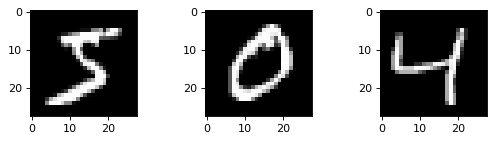

In [505]:
# Plot first images
fig = pyplot.figure(figsize=(8, 6), dpi=80)
for i in range(3):  
    fig.add_subplot(330 + 1 + i).imshow(raw_train_X[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [506]:
def draw_matrix(m):
    pyplot.figure(figsize=(6, 6), dpi=120)
    pyplot.imshow(m, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

### Prepare the data

Turn number-labels (e.g. 1) into vectors of probabilities (e.g. [0, 1, 0 ... 0])

In [507]:
def vectorize_mnist_output(ys):
    new_ys = np.empty((len(ys), 10))
    for i in range(len(ys)):
        vectorized_y = np.zeros(10)
        vectorized_y[ys[i]] = 1.0
        new_ys[i] = vectorized_y
        
    return new_ys

train_y = vectorize_mnist_output(raw_train_y)

test_y = vectorize_mnist_output(raw_test_y)

_ = [print("{} -> {}".format(raw, vectorized)) for (raw, vectorized) in zip(raw_train_y[:5], train_y[:5])]

5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Flatten inputs from 28x28 matrix to 728x1 vector and normalize to [0; 1]

In [515]:
rtx_shape = raw_train_X.shape
train_X = raw_train_X.reshape(rtx_shape[0], rtx_shape[1] * rtx_shape[2]) / 255

test_X = raw_test_X.reshape(raw_test_X.shape[0], raw_test_X.shape[1] * raw_test_X.shape[2]) / 255

print("inputs are now in range [{}; {}]".format(np.min(train_X), np.max(train_X)))

inputs are now in range [0.0; 1.0]


In [516]:
# compose X and y pairs into tuples
training_examples = list(zip(train_X, train_y))
test_examples = list(zip(test_X, test_y))
print("examples are of form: ({}, {})".format(training_examples[0][0].shape, training_examples[0][1].shape))

examples are of form: ((784,), (10,))


### Creating the network

In [517]:
mynet = Network([784, 30, 10])
print("created network with layer sizes {}".format(mynet.layer_sizes))

created network with layer sizes [784, 30, 10]


In [518]:
initial_error = mynet.error(test_examples)
print("error before training: {}".format(initial_error))

error before training: 2.758804430180685


### Training the network

In [ ]:

error_plot = mynet.SGD(training_examples, 20, 10, 3.0, test_data=test_examples)
 
fig = pyplot.figure()
ax = pyplot.axes()
 
ax.plot(range(len(error_plot)), error_plot)
print("Classified {} / {} examples correctly.".format(self.evaluate(test_examples), len(test_examples)))


  0%|          | 0/1200000 [00:00<?, ?it/s]

Epoch 0: 0.11423805346211444
Epoch 1: 0.06517145788645246
Epoch 2: 0.054097263403470756
Epoch 3: 0.05483387299742713
Epoch 4: 0.053919505619846486
Epoch 5: 0.048396031051603186
Epoch 6: 0.04738873797225213
Epoch 7: 0.04639469080731987
Epoch 8: 0.04710510602272485


### Classify!

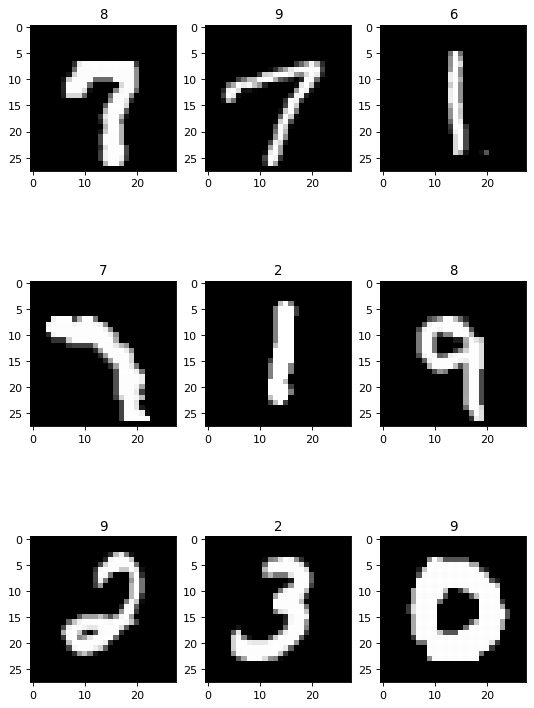

In [526]:
fig = pyplot.figure(figsize=(8, 12), dpi=80)
for i in range(9):  
    # pick a random test example
    X = test_X[random.randrange(len(test_X))]
    ax = fig.add_subplot(330 + 1 + i)
    
    model_output = np.argmax(mynet.feed_forward(X))
    ax.title.set_text(model_output)
    ax.imshow(X.reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    
pyplot.show()